In [1]:
#Importing packages
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd

In [2]:
#creating the model based on feature matrix and optimal beta coeficients
def betaAndYtildeGenerator(X_train,y_train):
    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
    ytilde = X_train @ beta
    return beta,ytilde


In [2]:
#Setting up the Feature matrix
def X_generator(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)  # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


In [3]:
# split in training and test data
def traningDataGenerator(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 11)
    return X_train, X_test, y_train, y_test

In [4]:
#Functions for R2 and MSE
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [5]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [6]:
#Function for generating noise
def noiseGeneration(z_input, scaling = 1):
    np.random.seed(5)
    nosyZ= z_input + np.random.randn(*z_input.shape) * scaling
    return nosyZ

In [7]:
#Fuction for making x and y of given size
def makeData(n_size=20):
    x = np.linspace(0,1,n_size)
    y = np.linspace(0,1,n_size)
    return x,y

In [8]:
#Scaling function for the feature matrix
def scale_data(X_train,X_test,y_train,y_test):
    scaler = StandardScaler()
    scaler_x = scaler.fit(X_train) # Scaling x-data
    X_train_scaled = scaler_x.transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    
    scaler_y = scaler.fit(y_train.reshape(-1,1))
    y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()
    return X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled

# Running Cross validation with manulay calculating 

Test MSE_scaled_cross val of degree0
1.0082684167426117
Test MSE_scaled_cross val of degree1
0.38468706460853336
Test MSE_scaled_cross val of degree2
0.32523849654239784
Test MSE_scaled_cross val of degree3
0.21717381839786848
Test MSE_scaled_cross val of degree4
0.16862175443874744
Test MSE_scaled_cross val of degree5
0.1425358189353874
Test MSE_scaled_cross val of degree6
0.13353403956789
Test MSE_scaled_cross val of degree7
0.12954690913723915
Test MSE_scaled_cross val of degree8
0.12466180434437797
Test MSE_scaled_cross val of degree9
0.13415708105790983
Test MSE_scaled_cross val of degree10
0.156487452153091


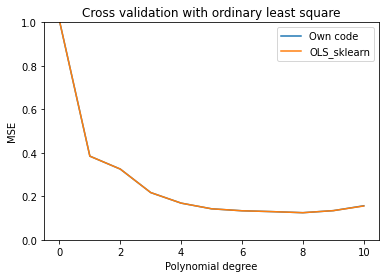

1.1842378929335003e-16


In [57]:
np.random.seed(870)
N = 20 #data size
x, y = makeData(N)
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh) 
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z,0.1)

k = 10 #Number of folds
kfold = KFold(n_splits = k, shuffle=True, random_state=22) 

#creating lists


numOfPoly_max = 10


numOfPoly_index = np.zeros(numOfPoly_max + 1)
beta_index = []
beta_index_scaled = []
mse_ols_cross_val = np.zeros(numOfPoly_max + 1)
mse_OLS_cval = np.zeros(numOfPoly_max + 1)
#for loop for number of polynomials
for i in range(numOfPoly_max +1 ):
    numOfPoly = i  
    X = X_generator(x_flat,y_flat, numOfPoly)
    if i>0:
        X = np.delete(X,0,1)
    Xs = X_generator(x_flat,y_flat,numOfPoly)
    mse_cross_val = np.zeros(k)
    mse_OLS_split = np.zeros(k)
    cv_split = 0
    for train_slice, test_slice in kfold.split(X):
        X_train = X[train_slice]
        X_test = X[test_slice]
        z_train = z[train_slice]
        z_test = z[test_slice]

        X_train, X_test, z_train,z_test = scale_data(X_train, X_test, z_train, z_test)
        #X_train[:,0] = 1
        #X_test[:,0] = 1


        beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
        z_intercept =  np.mean(z_train,axis=0)
        z_predict = X_test @ beta  + z_intercept
        mse_cross_val[cv_split] = mean_squared_error(z_test, z_predict)

        cv_split += 1
    cv_split = 0
    for train_slice, test_slice in kfold.split(Xs):
        X_train_s = Xs[train_slice]
        X_test_s = Xs[test_slice]
        z_train_s = z[train_slice]
        z_test_s = z[test_slice]
        X_train_s, X_test_s, z_train_s,z_test_s = scale_data(X_train_s, X_test_s, z_train_s, z_test_s)
        X_train_s[:,0] = 1
        X_test_s[:,0] = 1
        OLS_model = linear_model.LinearRegression(fit_intercept = False)
        OLS_model.fit(X_train_s, z_train_s)
        

        z_pred_ols = OLS_model.predict(X_test_s)
        mse_OLS_split[cv_split] = mean_squared_error(z_test_s, z_pred_ols)
        cv_split += 1
        
    numOfPoly_index[i] = numOfPoly
    mse_OLS_cval[i] = np.mean(mse_OLS_split)
    mse_ols_cross_val[i] = np.mean(mse_cross_val)
    print("Test MSE_scaled_cross val of degree{}".format(i))
    print(mse_ols_cross_val[i])



    
plt.plot(numOfPoly_index, mse_ols_cross_val, label = "Own code" ) 
plt.plot(numOfPoly_index, mse_OLS_cval, label = "OLS_sklearn")
plt.ylim(0,1)
plt.title("Cross validation with ordinary least square")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Polynomial degree")
plt.show()


#print("Training MSE_scaled")
#print(MSE(y_train,ytilde_scaled))


print(z_intercept)

# Comparing ridge lasso and OLS with cross validation

enter the max degree:10
max degree is : 10
Eureka


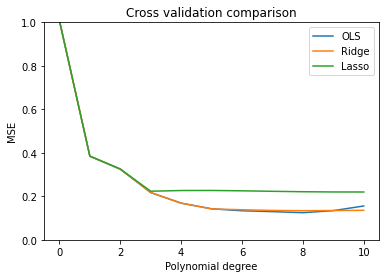

In [25]:
np.random.seed(870)
N = 20 #data size
x, y = makeData(N)
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh) 
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
z = noiseGeneration(z,0.1)
max_degree = input("enter the max degree:")
max_degree = int(max_degree)
print("max degree is :",max_degree)


degree_list = np.zeros(max_degree +1)
scaleData = True
lmb = 0.0001
k = 10 #Number of folds
kfold = KFold(n_splits = k, shuffle=True, random_state=22) 

#Error Lists:
mse_Ridge_cval = np.zeros(max_degree + 1)
mse_OLS_cval = np.zeros(max_degree + 1)
mse_Lasso_cval = np.zeros(max_degree + 1)

for degree in range(max_degree + 1):
    degree_list[degree] = degree
    X = X_generator(x_flat,y_flat, degree)
    if degree > 0:
        X = np.delete(X,0,1)
    mse_OLS_split = np.zeros(k)
    mse_Ridge_split = np.zeros(k)
    mse_Lasso_split = np.zeros(k)
    cv_split = 0
    
    
    for train_ind, test_ind in kfold.split(X):
        X_train = X[train_ind]
        X_test = X[test_ind]
        z_train = z[train_ind]
        z_test = z[test_ind]
        if scaleData == True:
            X_train, X_test, z_train, z_test = scale_data(X_train, X_test,z_train,z_test)
    
        #Creating models
        OLS_model = linear_model.LinearRegression(fit_intercept = True)
        OLS_model.fit(X_train, z_train)
        
        Ridge_model = linear_model.Ridge(lmb,fit_intercept = True)
        Ridge_model.fit(X_train,z_train)
    
        Lasso_model = linear_model.Lasso(lmb,max_iter=1e5, tol=0.1,fit_intercept = True)
        Lasso_model.fit(X_train,z_train)
    
        #Predicting 
        z_pred_ols = OLS_model.predict(X_test)
        z_pred_ridge = Ridge_model.predict(X_test)
        z_pred_lasso = Lasso_model.predict(X_test)
    
        #Calculating MSE for each fold
        mse_OLS_split[cv_split] = mean_squared_error(z_test, z_pred_ols)
        mse_Ridge_split[cv_split] = mean_squared_error(z_test, z_pred_ridge)
        mse_Lasso_split[cv_split] = mean_squared_error(z_test, z_pred_lasso)
        
        cv_split += 1
    
    mse_Ridge_cval[degree] = np.mean(mse_Ridge_split)
    mse_OLS_cval[degree] = np.mean(mse_OLS_split)
    mse_Lasso_cval[degree] = np.mean(mse_Lasso_split)

    
print("Eureka")

data = pd.DataFrame(columns =( ['mse_OLS', 'mse_ridge', 'mse_lasso']))

df = pd.DataFrame({"mse_cval_OLS":mse_OLS_cval,"mse_cval_Ridge":mse_Ridge_cval,"mse_cval_Lasso":mse_Lasso_cval}, index= degree_list)
df.index.name = "polynomial degree"
    
    
plt.plot(degree_list, mse_OLS_cval, label = "OLS")
plt.plot(degree_list, mse_Ridge_cval , label = "Ridge")
plt.plot(degree_list, mse_Lasso_cval, label = "Lasso")
plt.legend()
plt.ylim(0,1)
plt.title("Cross validation comparison")
plt.ylabel("MSE")
plt.xlabel("Polynomial degree")
plt.show()    





# The coefficients


In [35]:
df


,mse_cval_OLS,mse_cval_Ridge,mse_cval_Lasso
polynomial degree,,,
0.0,1.008268,1.008268,1.008268
1.0,0.384687,0.384687,0.384687
2.0,0.325238,0.325238,0.325225
3.0,0.217174,0.217173,0.223451
4.0,0.168622,0.168586,0.226647
5.0,0.142536,0.141998,0.226886
6.0,0.185993,0.138167,0.225294
7.0,0.210144,0.135061,0.223007
8.0,0.339164,0.133837,0.221064


# Creating data sett to higliht when scaling becomes more important
So acording to the same functionalities in sickit learn, one obtains the same fit As with our own code

In [52]:
def generate(median=630, err=12, outlier_err=100, size=80, outlier_size=10):
    errs = err * np.random.rand(size) * np.random.choice((-1, 1), size)
    data = median + errs

    lower_errs = outlier_err * np.random.rand(outlier_size)
    lower_outliers = median - err - lower_errs

    upper_errs = outlier_err * np.random.rand(outlier_size)
    upper_outliers = median + err + upper_errs

    data = np.concatenate((data, lower_outliers, upper_outliers))
    np.random.shuffle(data)

    return data

Plotting Data tat is generated through the code above

Text(0, 0.5, 'y')

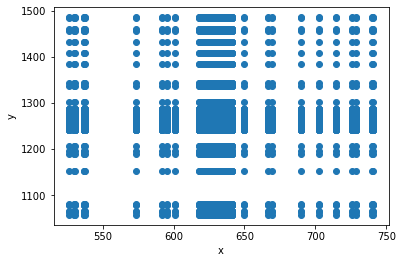

In [61]:
b = generate()

c = 5 + 2*b
b_mesh,c_mesh = np.meshgrid(b,c)
plt.scatter(b_mesh,c_mesh)
plt.xlabel("x")
plt.ylabel("y")

Plotting our case

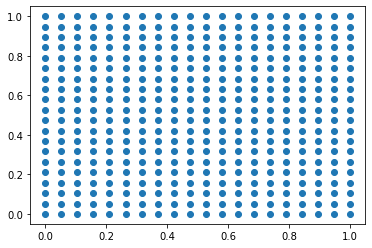

In [62]:
plt.scatter(x_mesh,y_mesh)